# Predicting Movie Genre using Machine Learning and Deep Learning

At this stage we will download data from IMDB and TMDB using APIs. Then we will clean, process and visualize the data. 

## <span style="color:#08088A">  Settings  </span>

### <span style="color:#08088A">  Needed libraries  </span>

In [4]:
import imdb
import numpy                  as np
import pandas                 as pd
import scipy                  as sp
import sklearn.neighbors      as knn
import matplotlib
import matplotlib.pyplot      as plt
import seaborn
import requests
import urllib
import joblib
import requests
import json
import os
import random
import seaborn as sns
#import statsmodels.api as sm
from matplotlib                           import rcParams
from sklearn                              import discriminant_analysis
from sklearn.decomposition                import PCA
from sklearn                              import preprocessing
from sklearn.linear_model                 import LogisticRegression as LogReg
from sklearn.discriminant_analysis        import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis        import QuadraticDiscriminantAnalysis as QDA
from scipy.stats                          import mode
from sklearn                              import linear_model
from IPython.core.interactiveshell        import InteractiveShell
from time                                 import sleep
from collections                          import Counter
from itertools                            import combinations, permutations
from urlparse                             import urljoin


In [5]:
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [6]:
matplotlib.style.use('ggplot')
rcParams['figure.figsize'] = (20, 10)
rcParams['axes.facecolor'] = "w"
rcParams['grid.color'] = "gray"
rcParams['grid.linewidth'] = 0.5

### <span style="color:#08088A">  API settings  </span>

In [9]:
api_key='insert_your_API_key' ## insert your API Keys do not use mine 

In [7]:
# setting for the discorver
movie_endpoint = 'http://api.themoviedb.org/3/movie/{movie_id}'
endpoint = 'http://api.themoviedb.org/3/discover/movie'

discover_params = {
        'sort_by':              'popularity.desc',
        'primary_release_year':  2016
        }
random_params = {
            'api_key'             :  'api_key',
            }



### <span style="color:#08088A">  Needed functions  </span>

In [8]:
def imdb_id_from_title(title):
    """ return IMDB id for search string

        Args::
            title (str): the movie title search string

        Returns: 
            str. IMDB id, e.g., 'tt0095016' 
            None. If no match was found

    """
    pattern = 'http://www.imdb.com/xml/find?json=1&nr=1&tt=on&q={movie_title}'
    url = pattern.format(movie_title=urllib.quote(title))
    r = requests.get(url)
    res = r.json()
    sleep(0.5)
    # sections in descending order or preference
    for section in ['popular','exact','substring']:
        key = 'title_' + section 
        if key in res:
            return res[key][0]['id']

In [9]:
def discover_tmdb_movies(max_pages, discover_params):
    
    """ return TMDB movies information for search string sorted by ranks and year. 
        This request is limited to a certain number of pages

        Args::
            max_pages   : the maximum number of page request
            discover_params : the TMDB API parameters 

        Returns: 
            movie list,
            None. If no match was found

    """
    
    discover_params.update(api_key = api_key)

    total_pages = json.loads(requests.get(endpoint, params = discover_params).text)['total_pages']

    movie_list = []
    for page_num in range(1, total_pages+1):
        if page_num > max_pages:
            break

        discover_params.update(page = page_num)
        reponse = requests.get(endpoint, params = discover_params)
        movie_list.extend(json.loads(reponse.text)['results'])
        sleep(0.06)

    return movie_list


In [10]:
def get_random_tmdb_movies(max_pages):
   
    """ return TMDB random movies information for search string . 
        This request is limited to a certain number of pages

        Args::
            max_pages   : the maximum number of page request

        Returns: 
            movie list,
            None. If no match was found

    """
    
    random_params.update(api_key = api_key)
    movie_list = []
    for page_num in range(1, max_pages+1):
        random_year = random.choice(range(1990, 2018))
        
        random_params.update(primary_release_year=random_year)
        
        total_pages = json.loads(requests.get(endpoint, params = random_params).text)['total_pages']
        random_result_page  =  random.choice(range(1, total_pages+1))
        discover_params.update({'page':  random_result_page})
        
        reponse = requests.get(endpoint, params = random_params)
        movie_list.extend(json.loads(reponse.text)['results'])
        sleep(0.06)

    return movie_list
    

In [11]:
def get_movie_info_from_tmdbid(tmdbid):
    sleep(0.05)
    response = requests.get(movie_endpoint.format(movie_id = tmdbid), params = {'api_key':api_key})
    return json.loads(response.text)

## <span style="color:#08088A">  Stage 1: Ask A Question  </span>

The exact form of X and Y depends on the ideas you had previously. In general though Y should involve the genre of a movie, and X the features you want to include to predict the genre. Remember from the lecture that more features does not necessarily equal better prediction performance. Use your application knowledge and the insight you gathered from your genre pair analysis and additional EDA to design Y. 

Do you want to include all genres? 

Are there genres that you assume to be easier to separate than others? 
Are there genres that could be grouped together? 

There is no one right answer here. We are looking for your insight, so be sure to describe your decision process in your notebook.
In preparation for the deep learning part we strongly encourage you to have two sets of training data X, one with the metadata and one with the movie posters. Make sure to have a common key, like the movie ID, to be able to link the two sets together. Also be mindful of the data rate when you obtain the posters. Time your requests and choose which poster resolution you need. In most cases w500 should be sufficient, and probably a lower resolution will be fine.
The notebook to submit this week should at least include:

Discussion about the imbalanced nature of the data and how you want to address it

Description of your data

What does your choice of Y look like?

Which features do you choose for X and why?

How do you sample your data, how many samples, and why?

## <span style="color:#08088A"> Stage 2: Get the Data  </span>

##  <span style="color:#08088A">  Movie Data:  </span> 


The project is based on two different sources of movie data: IMDb and TMDb. TMDb is great, because it provides the movie posters in addition to the metadata. This is crucial for the deep learning part, in which you will try to predict movie genres from posters. IMDb has more metadata available and will supplement the TMDb data you have.
TMDb provides an easy to use API that allows you to download the data selectively. IMDb does not provide an API, but there is a Python interface available to access the metadata. We will use IMDbPY, which is already installed on the AMI and virtual box images for your convenience.


###  <span style="color:#08088A">  Tmdb movie Data:  </span> 

In [3]:
## -----------------------------uncommented to use this code this code chunk---------------------------------------------

## contains limited information about the movies from the discovered end point
##discover_movie_list = discover_tmdb_movies(1, discover_params)
#random_movie_list = get_random_tmdb_movies(400)

##getting complete info from the movie end point (about discovered movies)


## with a for loop

#movie_info_list = [] # movies list form TMDB
#for index, movie in enumerate(random_movie_list):
    #print '\b' + str(index)
#    movie_info_list.append(get_movie_info_from_tmdbid(movie['id']))
#    sleep(0.05)


## with a for map function
##movie_info_list = map(get_movie_info_from_tmdbid, [movie['id'] for movie in random_movie_list])

#movie_info_list[:] = [x for x in movie_info_list if x['imdb_id'] != '' and x['imdb_id'] != None]

In [3]:
## -----------------------------uncommented to use this code this code chunk---------------------------------------------
#movie_info_list[:] = [x for x in movie_info_list if x['imdb_id'] != '' and x['imdb_id'] != None]
#joblib.dump(movie_info_list, 'movie_info_list.pkl')


In [12]:
movie_info_list = joblib.load('movie_info_list.pkl')

In [13]:
data_tmdb = pd.DataFrame(movie_info_list)

Some movies in tmdb dataset don't have imbd ID. To avoid error when requesting the imbd database, we will remove them.

In [14]:
len(data_tmdb), len(data_tmdb.imdb_id.unique())

(6512, 6407)

In [15]:
len(movie_info_list)

6512

In [16]:
data_tmdb['modified_genres'] = data_tmdb.genres.map(lambda x: [ [n for m,n in genre.items() if m == 'name'] for genre in x])
data_tmdb['modified_genres'] = data_tmdb['modified_genres'].map(lambda l: [genre for genre_list in l for genre in genre_list ])
data_tmdb[['original_title', 'modified_genres']].head()

,original_title,modified_genres
0,Black Eagle's Blade,[]
1,Het meisje met het rode haar,[]
2,Приключения Васи Куролесова,"[Mystery, Animation, Family, Comedy]"
3,L'année prochaine... si tout va bien,"[Drama, Comedy]"
4,Kill and Kill Again,[Action]


###  <span style="color:#08088A">  Imdb movie Data:  </span> 

In [17]:
## -----------------------------uncommented to use this code this code chunk---------------------------------------------
#handle = imdb.IMDb('http')
#imdb_movie_list = []

#for imdbID in [x['imdb_id'] for x in movie_info_list]:
    
#    imdb_movie_list.append(handle.get_movie(imdbID[2:len(imdbID)]))
#    sleep(0.05)

In [ ]:
## -----------------------------uncommented to use this code this code chunk---------------------------------------------
## saving the file
#joblib.dump(imdb_movie_list, 'imdb_movie_list.pkl')

In [19]:
## loading the file
imdb_movie_list = joblib.load('imdb_movie_list.pkl')

In [20]:
imdb_movie_list_1 = [{k: x[k] for k in ('title', 'genres')} for x in imdb_movie_list[0:10]]

In [24]:
imdb_movie_list[1]

In [25]:
data_imdb = pd.DataFrame(imdb_movie_list)

In [26]:
#data_imdb.head()

###  <span style="color:#08088A">  Merged Data:  </span> 

In [28]:
# we have to merge two infos- movie_info_list and imdb_movie_list
# get all fields for movie - movie_info_list[1].keys()

##---------------------------------------the features needed in our two database----------------------------------------------

imdb_info_subset = ['imdb_id', 'title', 'year', 'genres', 'director', 
                    'cast', 'writer', 'rating', 'votes', 'runtimes',]
tmdb_info_subset = ['imdb_id', 'overview', 'budget', 'genres', 'poster_path', 
                   'popularity', 'production_companies', 'production_countries',
                   'release_data', 'runtime', 'vote_average', 'vote_count',
                   'tagline','status', 'adult']

# prepare imdb data list

[x.data.update({'imdb_id': 'tt' + x.getID()}) for x in imdb_movie_list]
extracted_imdb_movie_list = [x.data for x in imdb_movie_list]

## subset fields for imdb and tmdb lists

final_tmdb_list = [ {x:y for x, y in movie.items() if x in tmdb_info_subset} for movie in movie_info_list]
final_imdb_list = [ {x:y for x, y in movie.items() if x in imdb_info_subset} for movie in extracted_imdb_movie_list]

tmdb_df = pd.DataFrame(final_tmdb_list)
imdb_df = pd.DataFrame(final_imdb_list)

## convert genre dictionary to list
tmdb_df['genres'] = tmdb_df.genres.map(lambda x: [ [n for m,n in genre.items() if m == 'name'] for genre in x])
tmdb_df['genres'] = tmdb_df['genres'].map(lambda l: [genre for genre_list in l for genre in genre_list ])


merged_mdb = pd.merge(tmdb_df, imdb_df, on='imdb_id')

###  <span style="color:#08088A">  EDA:  </span> 

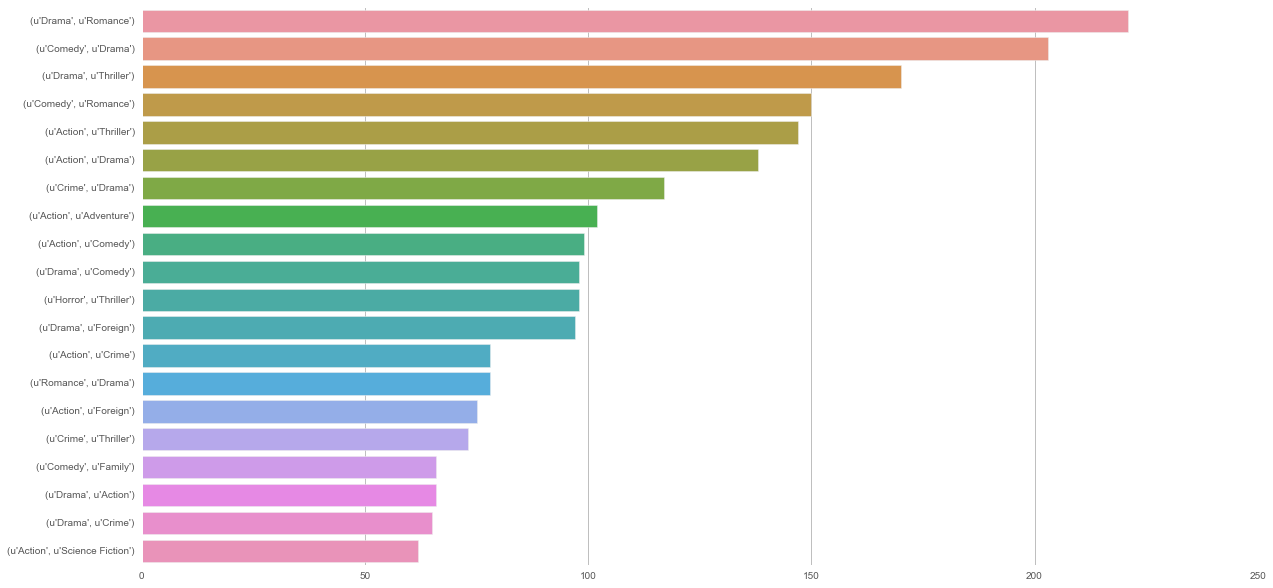

In [31]:
# genre paired occurence

paired_genres = list(data_tmdb.modified_genres.map(lambda x : list(combinations(x, 2))))
flattened_genre_pairs = [pair for sublist in paired_genres for pair in sublist]
pair_counter = Counter(flattened_genre_pairs)
count_pair_list = zip(pair_counter, pair_counter.values())

sorted_count_pair_list = sorted(count_pair_list, key= lambda x: x[1], reverse=True)[0:20]

seaborn.barplot([x[1] for x in sorted_count_pair_list],[str(x[0]) for x in sorted_count_pair_list] )

In [29]:
data_tmdb['pairs'] = data_tmdb.modified_genres.map(lambda x : list(combinations(x, 2)))
melted_genre_pairs_movie = pd.DataFrame(pd.concat([pd.Series(row['original_title'], row['pairs']) for x, row in data_tmdb.iterrows()])).reset_index()

In [32]:
melted_genre_pairs_movie.columns = ['genre_pair', 'original_title']
# melted_genre_pairs_movie.head(20)
grouped_genre_pairs_movie = melted_genre_pairs_movie.groupby('genre_pair')['original_title'].agg({'titles': lambda x : ', '.join(x)}).reset_index()
grouped_genre_pairs_movie.columns = ['genre_pair', 'titles']

plot_data = pd.DataFrame(sorted_count_pair_list, columns=['genre_pair', 'count'])

In [33]:
merged_data = pd.merge(plot_data, grouped_genre_pairs_movie, on = 'genre_pair', how= 'inner')

###  <span style="color:#08088A">  Poster data:  </span> 

In [ ]:
## getting images

base_path = 'https://image.tmdb.org/t/p/{size}/'
local_poster_folder = os.path.expanduser('~/poster_folder')

if not os.path.exists(local_poster_folder):
    os.mkdir(local_poster_folder)

tmdb_df['poster_url'] = tmdb_df.poster_path.map(lambda path: urljoin(base_path.format(size = 'w500'), path.replace('/', '')))
# add absolute paths for images
tmdb_df['local_poster_path'] = tmdb_df.poster_path.map(lambda path: os.path.join(local_poster_folder, path.replace('/', '')))

def save_image_to_local(image_url, local_path):
    import requests
    response = requests.get(image_url)
    with open(local_path, 'w+') as f:
        f.write(response.content)
    pass

# downloading images to local paths
tmdb_df[['poster_url', 'local_poster_path']].apply(axis = 1, func = lambda x: save_image_to_local(x[0], x[1]))
    


In [ ]:
###  <span style="color:#08088A">  Clean data:  </span> 


We need to clean the data before making any analysis as there are dictionaries inside the dataframe and multiple labels under one column such as in genres, production country and production company. 



In [36]:
tmdb_df = pd.DataFrame(movie_info_list)

In [37]:
## convert dictionaries to list
tmdb_df['genres'] = tmdb_df.genres.map(lambda x: [ [n for m,n in genre.items() if m == 'name'] for genre in x])
tmdb_df['genres'] = tmdb_df['genres'].map(lambda l: [genre for genre_list in l for genre in genre_list ])

tmdb_df['production_companies'] = tmdb_df.production_companies.map(lambda x: [ [n for m,n in lang.items() if m == 'name'] for lang in x])
tmdb_df['production_companies'] = tmdb_df['production_companies'].map(lambda l: [lang for lang_list in l for lang in lang_list ])

tmdb_df['production_countries'] = tmdb_df.production_countries.map(lambda x: [ [n for m,n in lang.items() if m == 'name'] for lang in x])
tmdb_df['production_countries'] = tmdb_df['production_countries'].map(lambda l: [lang for lang_list in l for lang in lang_list ])

#Split multiple genre labels into different columns - then keep only the first one
#This is for correlation and visualisation analysis only
tmdb_df = pd.concat([tmdb_df.drop(['genres'], axis=1), tmdb_df['genres'].apply(pd.Series)], axis=1)
tmdb_df = tmdb_df.drop([1], axis=1)
tmdb_df = tmdb_df.drop([2], axis=1)
tmdb_df = tmdb_df.drop([3], axis=1)
tmdb_df = tmdb_df.drop([4], axis=1)
tmdb_df = tmdb_df.drop([5], axis=1)
tmdb_df = tmdb_df.drop([6], axis=1)
tmdb_df.rename(columns={0: 'genres'}, inplace=True)

#Split multiple production company labels into different columns - then keep only the first one
tmdb_df = pd.concat([tmdb_df.drop(['production_companies'], axis=1), tmdb_df['production_companies'].apply(pd.Series)], axis=1)
tmdb_df = tmdb_df.drop([1], axis=1)
tmdb_df = tmdb_df.drop([2], axis=1)
tmdb_df = tmdb_df.drop([3], axis=1)
tmdb_df = tmdb_df.drop([4], axis=1)
tmdb_df = tmdb_df.drop([5], axis=1)
tmdb_df = tmdb_df.drop([6], axis=1)
tmdb_df = tmdb_df.drop([7], axis=1)
tmdb_df = tmdb_df.drop([8], axis=1)
tmdb_df = tmdb_df.drop([9], axis=1)
tmdb_df = tmdb_df.drop([10], axis=1)
tmdb_df = tmdb_df.drop([11], axis=1)
tmdb_df.rename(columns={0: 'production_company'}, inplace=True)

#Split multiple production country labels into different columns - then keep only the first one
tmdb_df = pd.concat([tmdb_df.drop(['production_countries'], axis=1), tmdb_df['production_countries'].apply(pd.Series)], axis=1)
tmdb_df = tmdb_df.drop([1], axis=1)
tmdb_df = tmdb_df.drop([2], axis=1)
tmdb_df = tmdb_df.drop([3], axis=1)
tmdb_df = tmdb_df.drop([4], axis=1)
tmdb_df = tmdb_df.drop([5], axis=1)
tmdb_df = tmdb_df.drop([6], axis=1)
tmdb_df.rename(columns={0: 'production_country'}, inplace=True)


In [38]:
#Delete features that will not be of interest for correlation/visualization analysis

tmdb_df = tmdb_df.drop(['belongs_to_collection'], axis=1)
tmdb_df = tmdb_df.drop(['backdrop_path'], axis=1)
tmdb_df = tmdb_df.drop(['homepage'], axis=1)
tmdb_df = tmdb_df.drop(['poster_path'], axis=1)
tmdb_df = tmdb_df.drop(['spoken_languages'], axis=1)
tmdb_df = tmdb_df.drop(['release_date'], axis=1)
tmdb_df = tmdb_df.drop(['video'], axis=1)
tmdb_df = tmdb_df.drop(['title'], axis=1)
tmdb_df = tmdb_df.drop(['imdb_id'], axis=1)
tmdb_df = tmdb_df.drop(['original_title'], axis=1)
tmdb_df = tmdb_df.drop(['tagline'], axis=1)
tmdb_df = tmdb_df.drop(['status'], axis=1)
tmdb_df = tmdb_df.drop(['id'], axis=1)
tmdb_df = tmdb_df.drop(['adult'], axis=1)


###  <span style="color:#08088A">  NATURAL LANGUAGE PROCESSING OF PLOT SUMMARIES:  </span> 



Our aim is to analyse plot summaries by turning each plot into a vector of features. We will tokenize and count the word occurrences using a bag of words approach. Individual token occurrence frequency will be treated as a feature, as features will then enable us to predict the genre. 

In [39]:
tmdb_df['overview'].fillna(value=np.nan, inplace=True)
print(tmdb_df['overview'])

0       Taiwan sword fighter Roc Tien leads the charge...
1       During the second world war law student Hannie...
2       A comic mystery about Vasia Kurolesov who is t...
3       Isabelle and Maxime are a pair of lighthearted...
4       Dr. Horatio Kane has been kidnapped, and is be...
5       It all starts when Teacher Sayuri tries to hel...
6       Heartbeeps stars Andy Kaufman and Bernadette P...
7       A mad cap private-eye caper about a team of de...
8       Criminal genius Egon Olsen presents his accomp...
9       After the hero Julio Valiente was ambushed by ...
10      In a small college in North Carolina, only a s...
11      A young man grows up in Sarajevo in the 1960s,...
12      Three lovely waitresses contend with a drunken...
13      A teacher, Sakiko Kurata (Yuki Kazamatsuri), r...
14      A historical drama set in the 1400s, a young m...
15      The story concerns with Danny Lee's character ...
16      The film is a series of interviews with variou...
17            

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english',decode_error='ignore',analyzer='word', min_df=4)

corpus = tmdb_df['overview'].values.astype('U')

In [41]:
wordvec = vectorizer.fit_transform(corpus.ravel())
wordvec = wordvec.toarray()
words = vectorizer.get_feature_names()
print("number of words: ", len(words))
print("Print first 300 words:")
print(words[1:300])

('number of words: ', 6668)
Print first 300 words:
[u'10', u'100', u'11', u'12', u'13', u'14', u'15', u'16', u'16th', u'17', u'17th', u'18', u'18th', u'19', u'1918', u'1919', u'1920s', u'1926', u'1930', u'1930s', u'1936', u'1939', u'1940', u'1940s', u'1942', u'1943', u'1944', u'1945', u'1950', u'1950s', u'1955', u'1958', u'1960', u'1960s', u'1963', u'1964', u'1966', u'1967', u'1968', u'1969', u'1970', u'1970s', u'1971', u'1972', u'1973', u'1974', u'1975', u'1976', u'1977', u'1978', u'1979', u'1980', u'1980s', u'1981', u'1982', u'1983', u'1984', u'1985', u'1986', u'1987', u'1988', u'1989', u'1990', u'1990s', u'1991', u'1992', u'1993', u'1994', u'1995', u'1996', u'1997', u'1998', u'1999', u'19th', u'20', u'200', u'2000', u'2001', u'2002', u'2003', u'2004', u'2005', u'2006', u'2007', u'2008', u'2009', u'2010', u'2011', u'2012', u'2013', u'2014', u'20th', u'21', u'21st', u'22', u'23', u'24', u'25', u'26', u'27', u'29', u'30', u'300', u'30s', u'35', u'40', u'40s', u'45', u'48', u'50', u'500

In [44]:
# Merge plot summaries with metadata
plot_db = pd.DataFrame(wordvec,columns=words)
plot_db.head(n=5)
tmdb_df = tmdb_df.drop(['overview'], axis=1)
tmdb_df = pd.concat([tmdb_df, plot_db], axis=1)
tmdb_df.shape

,000,10,100,11,12,13,14,15,16,16th,...,zhang,zombie,zombies,zone,его,на,не,он,что,это
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(6512, 6678)

In [45]:
#Most observed words in plot summaries
plot_db.sum(axis=0).sort_values(ascending=False)[0:50]

film           1039
life            863
young           761
man             717
new             600
story           593
love            588
family          536
nan             528
woman           496
world           491
old             471
time            460
years           404
girl            363
people          344
father          338
son             332
wife            328
finds           321
friends         319
year            316
mother          313
day             311
documentary     306
lives           306
home            302
way             285
friend          271
movie           266
takes           264
war             261
help            259
gets            259
town            258
daughter        257
live            254
city            246
just            243
school          241
women           239
soon            238
death           237
make            236
like            235
set             225
boy             220
work            218
group           215
small           211


###  <span style="color:#08088A">  Deal with Categorical Data:  </span> 

In [43]:
#Assign genre as a categorical variable
tmdb_df['genres'] = tmdb_df['genres'].astype('category')
#Calculate genre frequency
tmdb_df['genres'].value_counts()

Drama              1268
Comedy              857
Documentary         477
Action              441
Horror              273
Thriller            186
Animation           162
Crime               151
Romance             131
Adventure           110
Music               103
Family               97
Science Fiction      92
TV Movie             84
Fantasy              75
Mystery              51
Foreign              38
War                  38
History              30
Western              19
Name: genres, dtype: int64

It is apparent that our data is not balanced, with a target variable range from 19 to 1268 number of occurances.

Let's check other variables also:

In [46]:
#Assign categorical variables
tmdb_df['genres'] = tmdb_df['genres'].astype('category')
tmdb_df['production_company'] = tmdb_df['production_company'].astype('category')
tmdb_df['production_country'] = tmdb_df['production_country'].astype('category')
tmdb_df['original_language'] = tmdb_df['original_language'].astype('category')

#Count unique values
ColumnStats = pd.DataFrame(columns=['Column','Type','UniqueValues'])
for c in tmdb_df.columns:
    ColumnStats.loc[len(ColumnStats)]=[tmdb_df[c].name,tmdb_df[c].dtype,len(set(tmdb_df[c]))]

ColumnStats.sort_values(by=['UniqueValues'], ascending=[0], inplace = True)
print(ColumnStats.head(30))

AttributeError: 'DataFrame' object has no attribute 'name'

It seems that our categorical variables such as genre, production country etc. have all more than 20 unique values. It would be better to convert them into numerical variables instead of using one hot encoding to get dummy variables. 

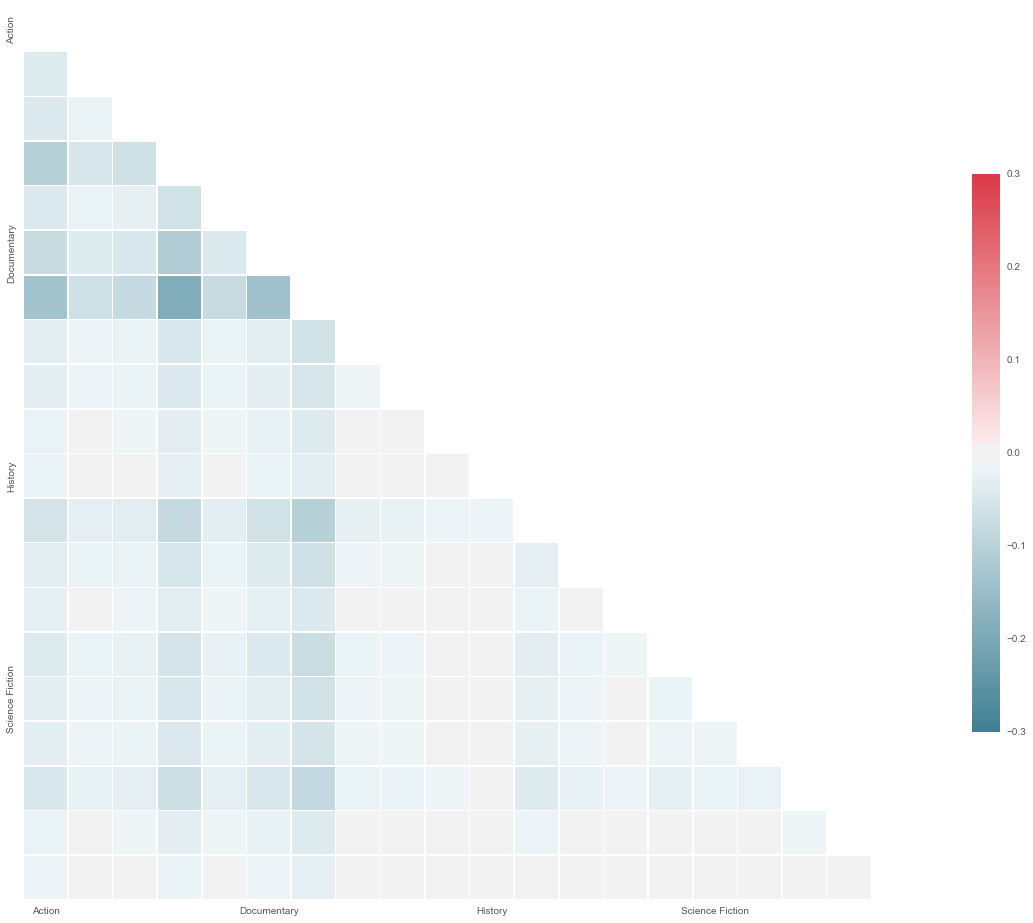

In [49]:
import seaborn as sns
fig = plt.figure(figsize=(20, 20))
# Compute the correlation matrix
corr = genrematrix.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": 0.5}, ax=ax);

It seems that there is very little correlation between the genres

In [50]:
#Assign caterical variables with numerical numbers for correlation analysis
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(tmdb_df['genres'])
tmdb_df['genres'] = le.transform(tmdb_df['genres']) 
le.fit(tmdb_df['production_country'])
tmdb_df['production_country'] = le.transform(tmdb_df['production_country']) 
le.fit(tmdb_df['production_company'])
tmdb_df['production_company'] = le.transform(tmdb_df['production_company']) 
le.fit(tmdb_df['original_language'])
tmdb_df['original_language'] = le.transform(tmdb_df['original_language']) 


/Users/gerardnignon/Applications/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


LabelEncoder()

/Users/gerardnignon/Applications/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


LabelEncoder()

LabelEncoder()

LabelEncoder()

###  <span style="color:#08088A">  Correlation Analysis:  </span> 


Now let's look at summary statistics of our cleaned data. 

In [51]:
tmdb_df.describe()

/Users/gerardnignon/Applications/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,genres,production_company,production_country,...,zhang,zombie,zombies,zone,его,на,не,он,что,это
count,6.512000e+03,6512.000000,6512.000000,6.512000e+03,5985.000000,6512.000000,6512.000000,6512.000000,6512.000000,6512.000000,...,6512.000000,6512.000000,6512.000000,6512.000000,6512.000000,6512.000000,6512.000000,6512.000000,6512.000000,6512.000000
mean,9.691541e+05,18.189189,0.079249,3.102729e+06,74.381119,2.853701,22.864711,5.201628,418.454853,35.787162,...,0.000614,0.000921,0.002150,0.001382,0.001536,0.001075,0.001382,0.001229,0.001382,0.000614
std,6.755448e+06,10.757552,0.331883,2.913064e+07,128.841770,3.144566,208.074672,5.083367,599.451970,36.066793,...,0.024778,0.030343,0.049525,0.041080,0.067862,0.054009,0.051079,0.065566,0.059419,0.024778
min,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,14.000000,0.000164,0.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000e+00,14.000000,0.001259,0.000000e+00,NaN,0.000000,0.000000,4.000000,0.000000,30.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000e+00,14.000000,0.028852,0.000000e+00,NaN,6.000000,2.000000,7.000000,823.250000,77.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.500000e+08,63.000000,8.805567,8.362972e+08,9120.000000,10.000000,6817.000000,20.000000,1866.000000,94.000000,...,1.000000,1.000000,2.000000,2.000000,4.000000,4.000000,3.000000,5.000000,4.000000,1.000000


It seems that average runtime is 74 minutes but there are also outliers that do not make sense such as 9120 minutes. Can this be in seconds?  

In [52]:
#Calculate correlation matrix
corr_matrix = tmdb_df.corr(method='pearson')

In [ ]:
#Calculate correlation matrix


fig = plt.figure(figsize=(20, 20))
# Compute the correlation matrix
#Calculate correlation matrix
corr_matrix = tmdb_df.corr(method='pearson')

# Display heat map 
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.pcolor(corr_matrix, vmin=-1, vmax=1)
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticklabels(corr_matrix.columns)
ax.set_xticks(np.arange(0, len(corr_matrix), 1))
ax.set_yticks(np.arange(0, len(corr_matrix), 1))
ax.set_title('Heatmap of correlation matrix')
plt.show()

In [54]:
#Delete correlation with self for genre
corr_matrix = corr_matrix.drop(['genres'])
#Calculate correlation with genres in descending order
corr_matrix['genres'].sort_values(ascending=False)
ass_corr = corr_matrix['genres'].sort_values(ascending=False)
#Report which variables are most correlated with genre
print("Correlation with Genre")
print(ass_corr)

production_country    0.260081
production_company    0.214784
vote_average          0.100941
murdered              0.084242
thriller              0.081148
runtime               0.078011
horror                0.074962
killer                0.064320
isolated              0.059468
complicated           0.058561
supernatural          0.057879
soon                  0.056742
nightmares            0.056605
alien                 0.055749
basement              0.054783
daughter              0.052097
serial                0.051383
arena                 0.050357
dead                  0.049936
death                 0.049864
curse                 0.049099
convict               0.048395
god                   0.048222
web                   0.047974
begins                0.047874
terrible              0.047792
murdering             0.047398
popularity            0.047334
android               0.046891
young                 0.046603
                        ...   
kong                 -0.030294
document

Correlation with Genre
production_country    0.260081
production_company    0.214784
vote_average          0.100941
murdered              0.084242
thriller              0.081148
runtime               0.078011
horror                0.074962
killer                0.064320
isolated              0.059468
complicated           0.058561
supernatural          0.057879
soon                  0.056742
nightmares            0.056605
alien                 0.055749
basement              0.054783
daughter              0.052097
serial                0.051383
arena                 0.050357
dead                  0.049936
death                 0.049864
curse                 0.049099
convict               0.048395
god                   0.048222
web                   0.047974
begins                0.047874
terrible              0.047792
murdering             0.047398
popularity            0.047334
android               0.046891
young                 0.046603
                        ...   
kong            

In [57]:
#print(corr_matrix[1:10,1:10])

(0, 25.0)

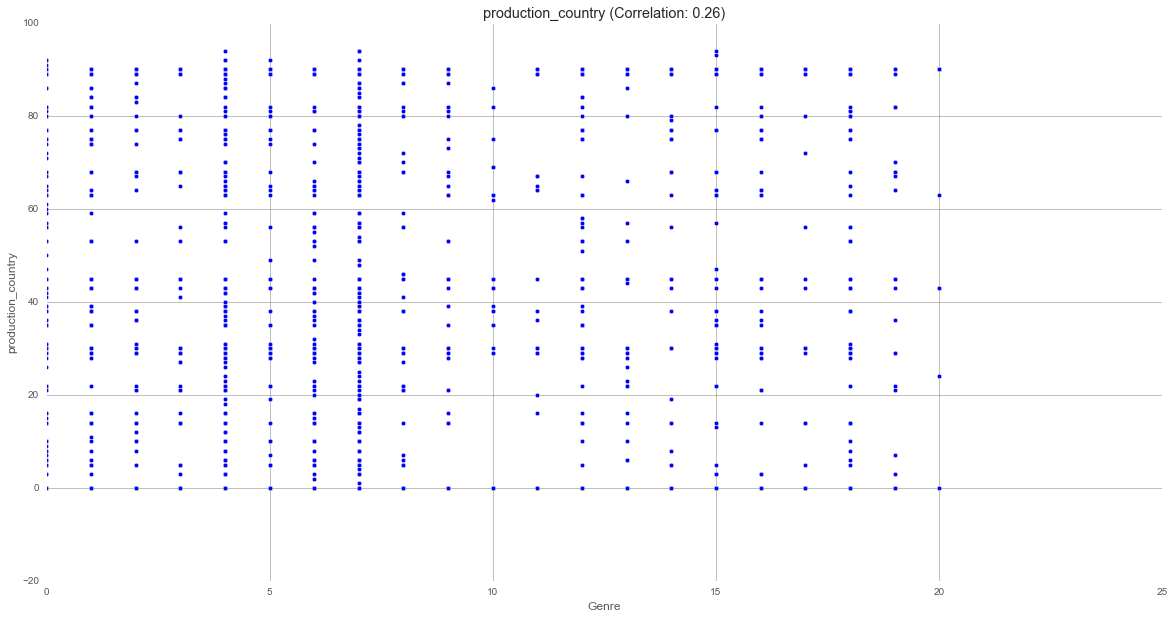

(0, 25.0)

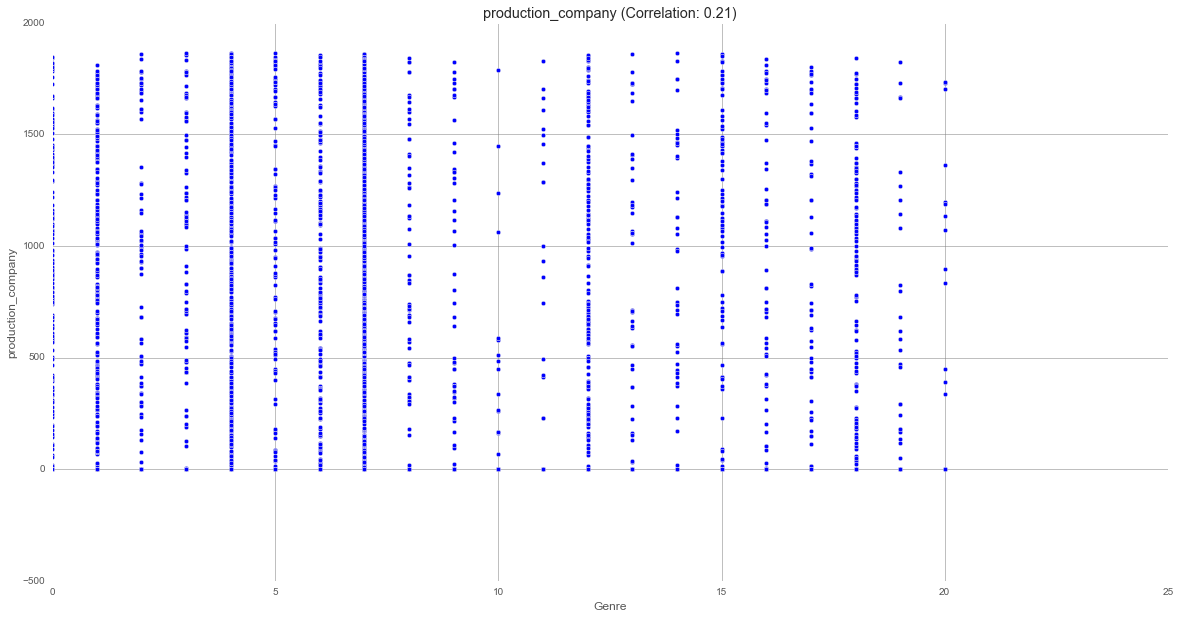

(0, 25.0)

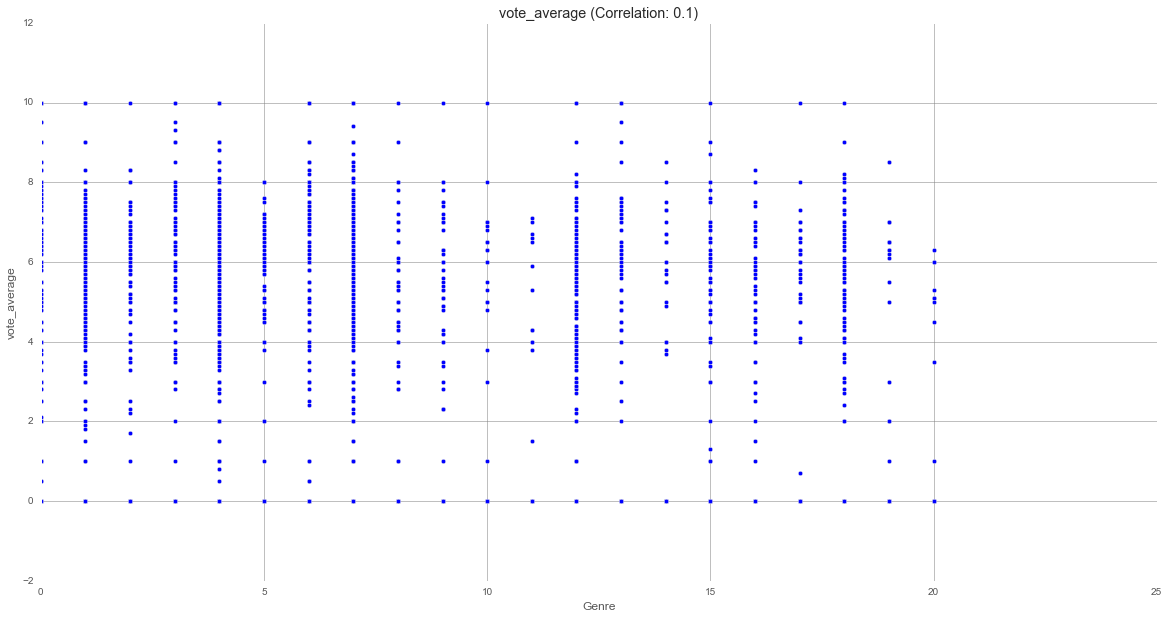

(0, 25.0)

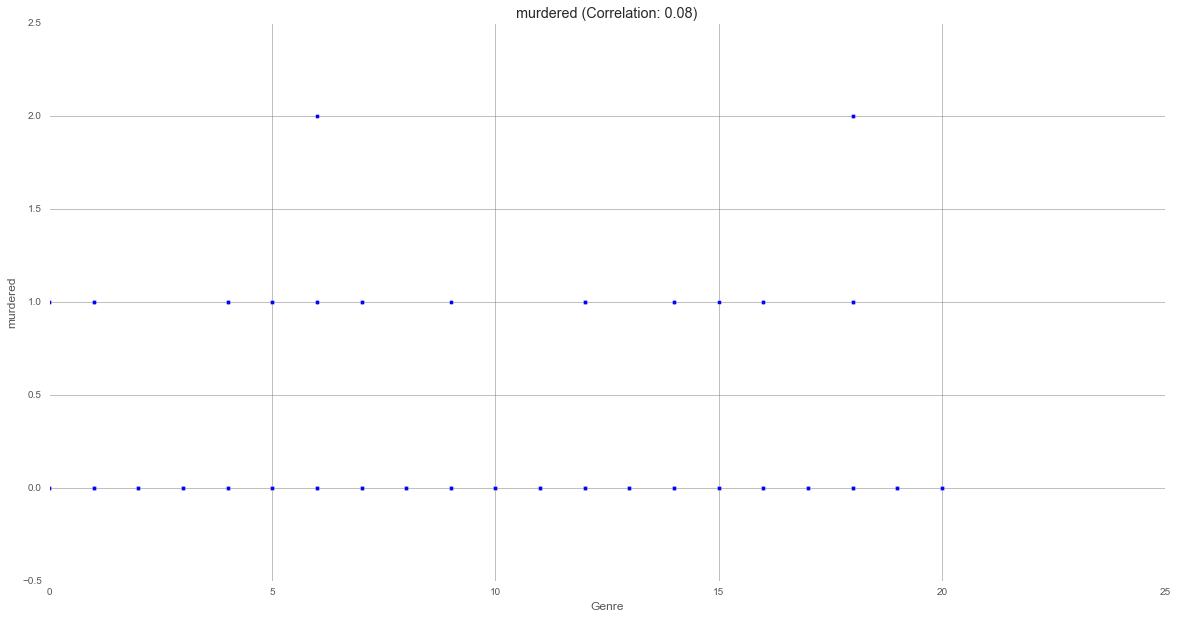

(0, 25.0)

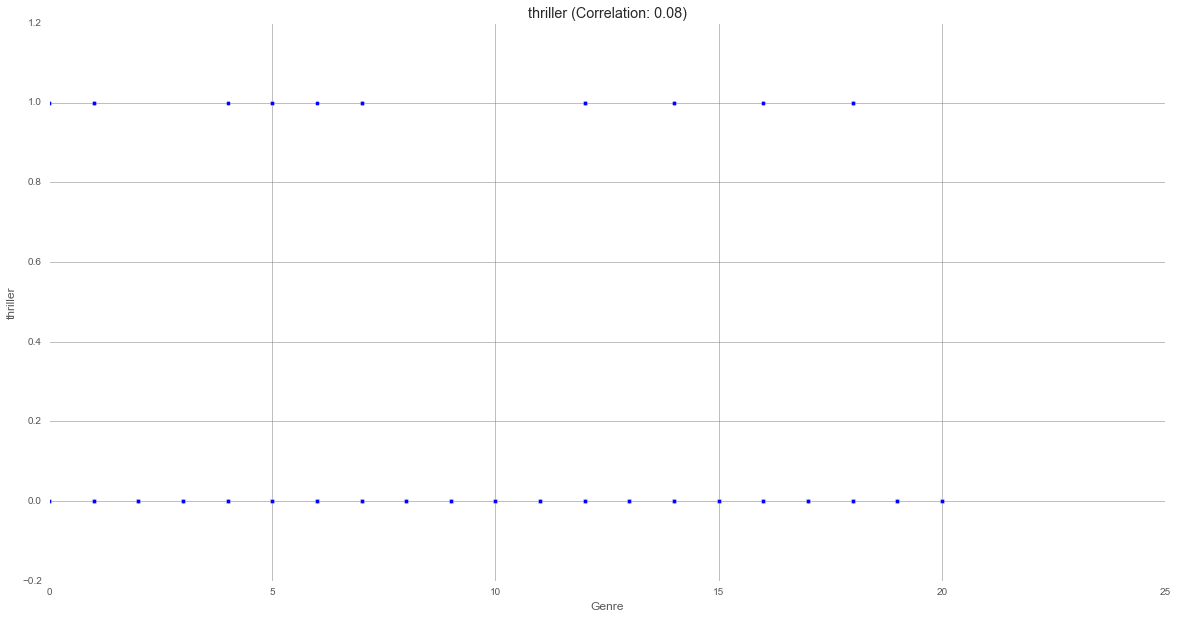

(0, 25.0)

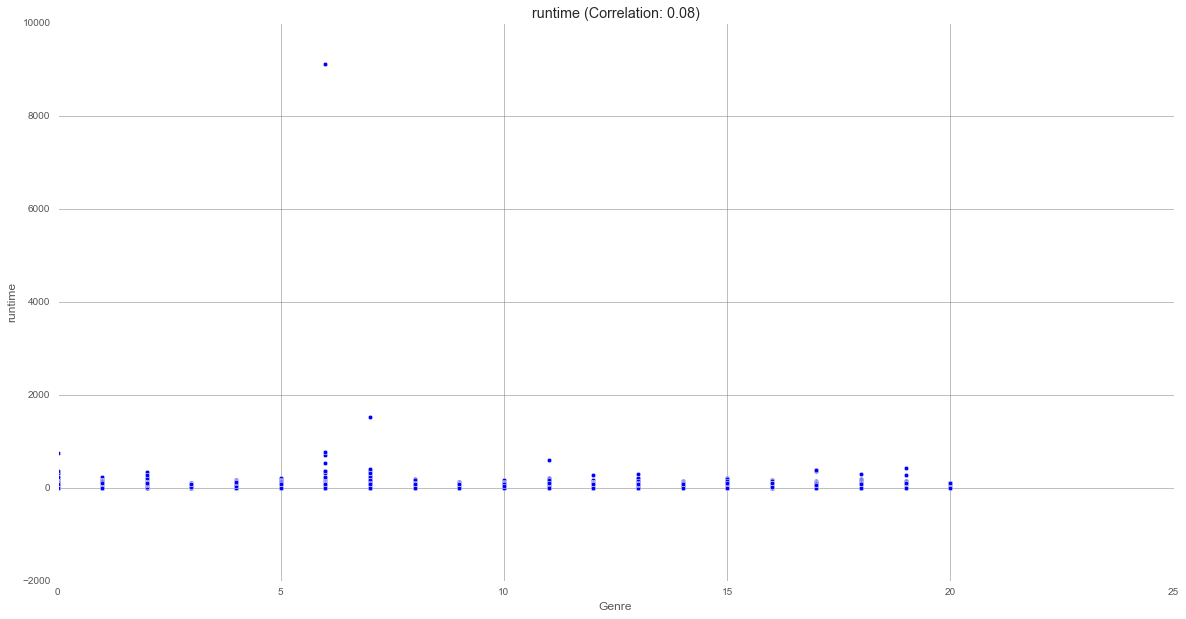

(0, 25.0)

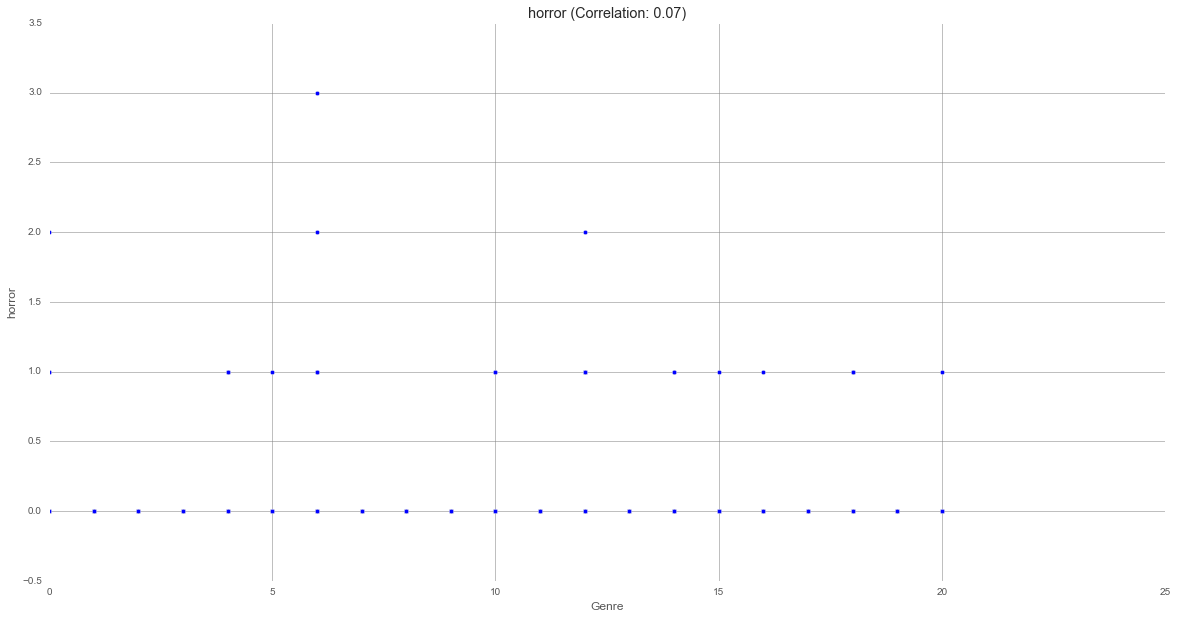

(0, 25.0)

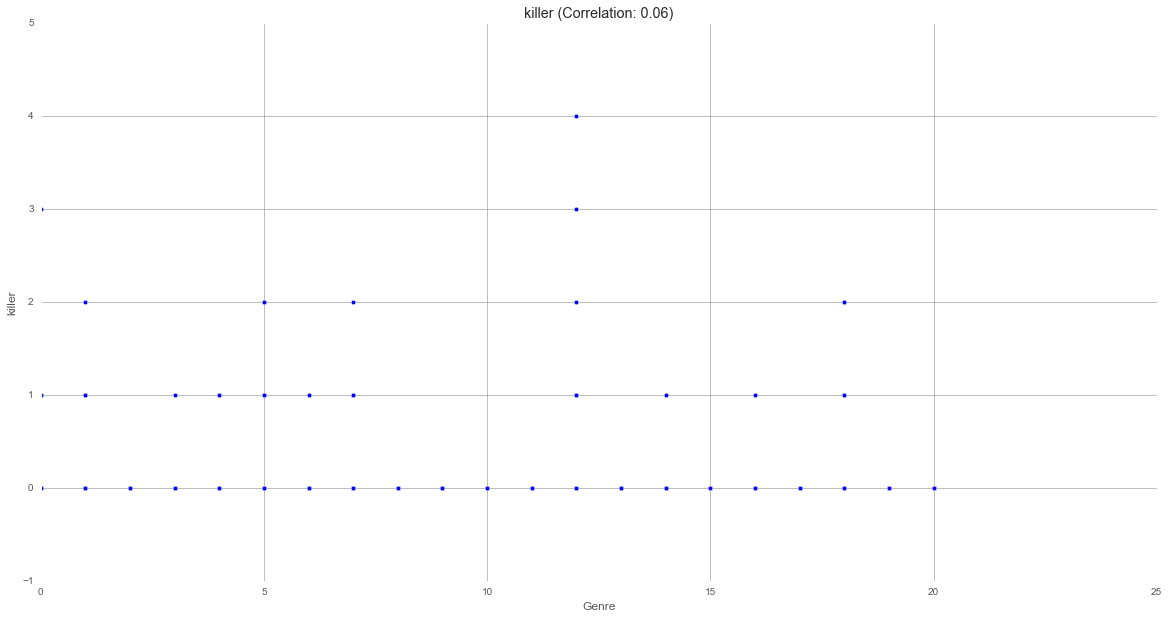

(0, 25.0)

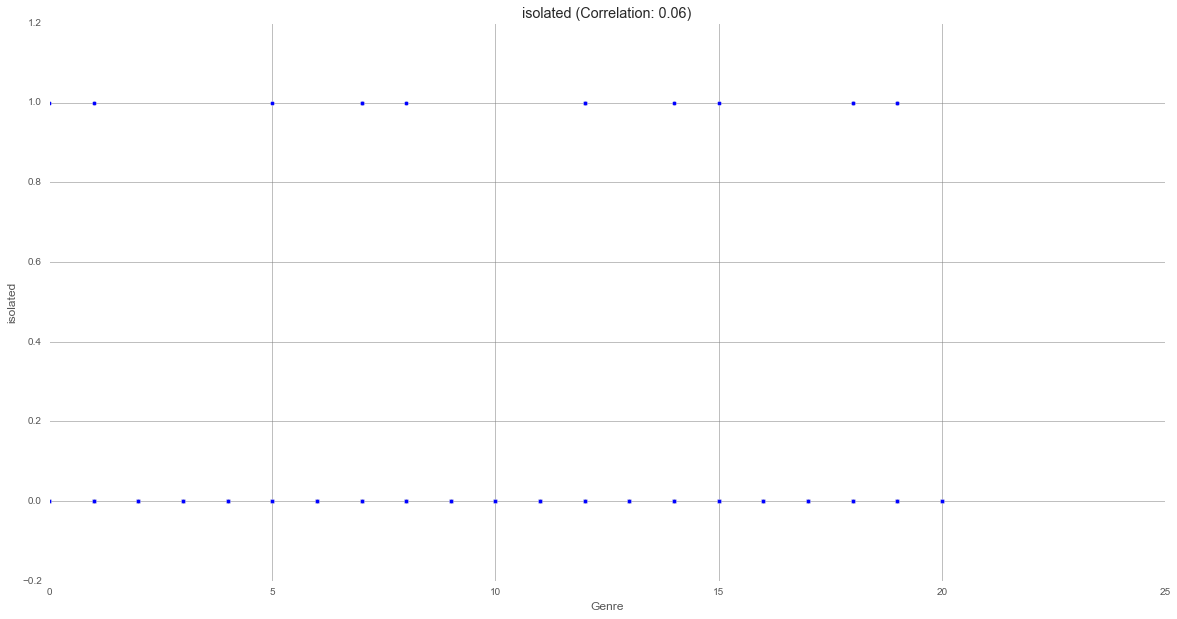

(0, 25.0)

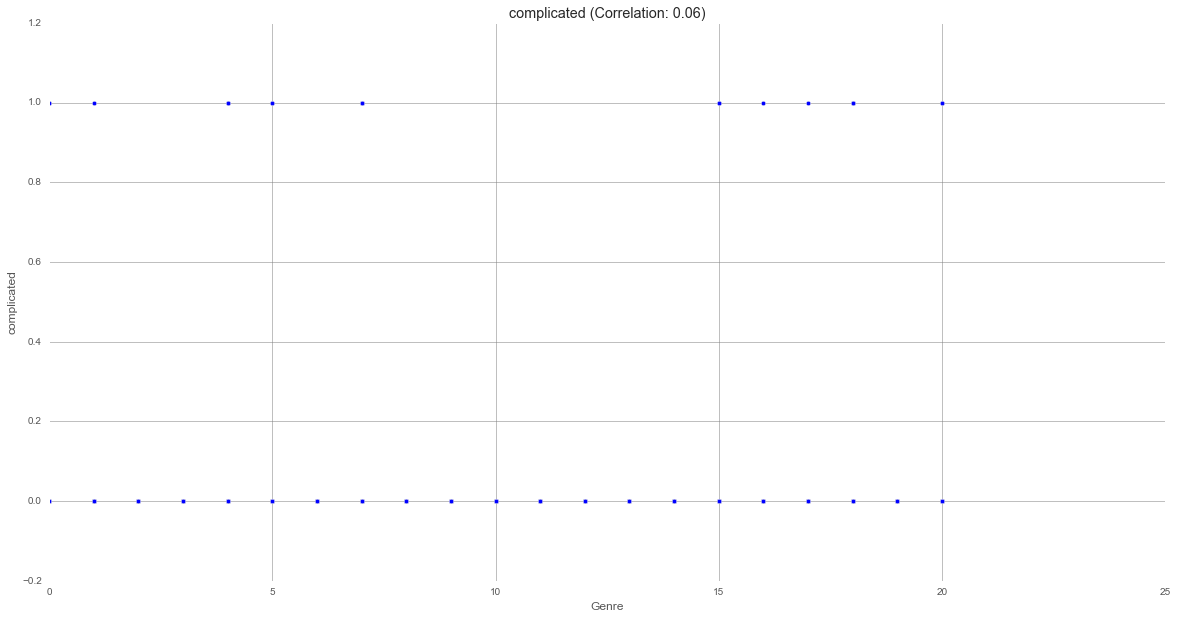

(0, 25.0)

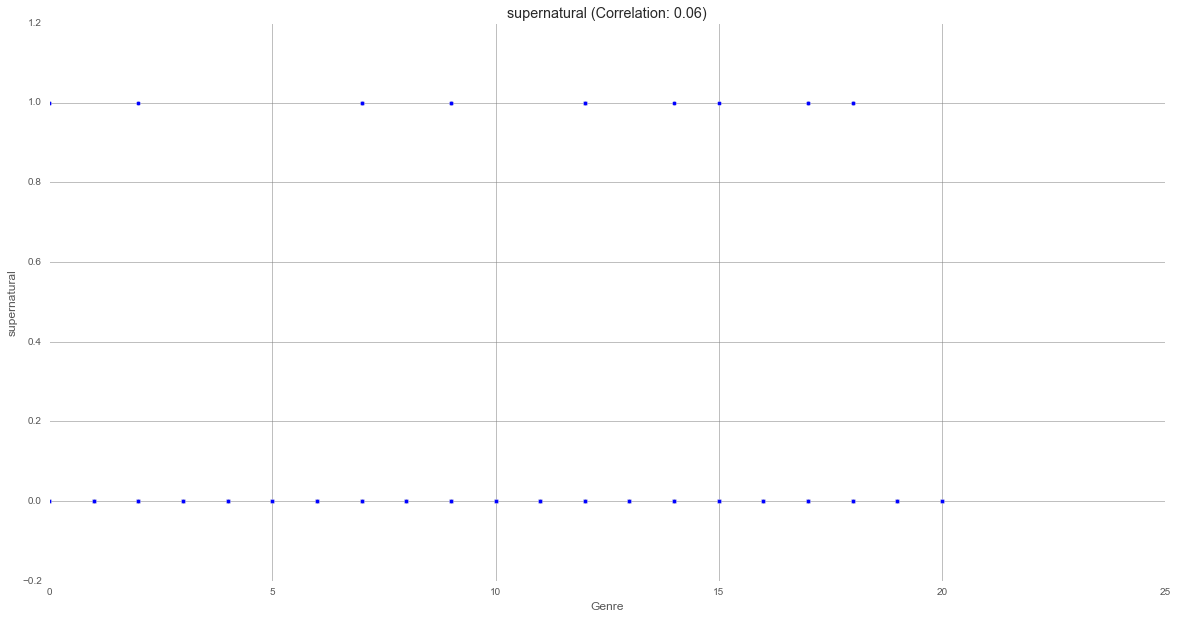

(0, 25.0)

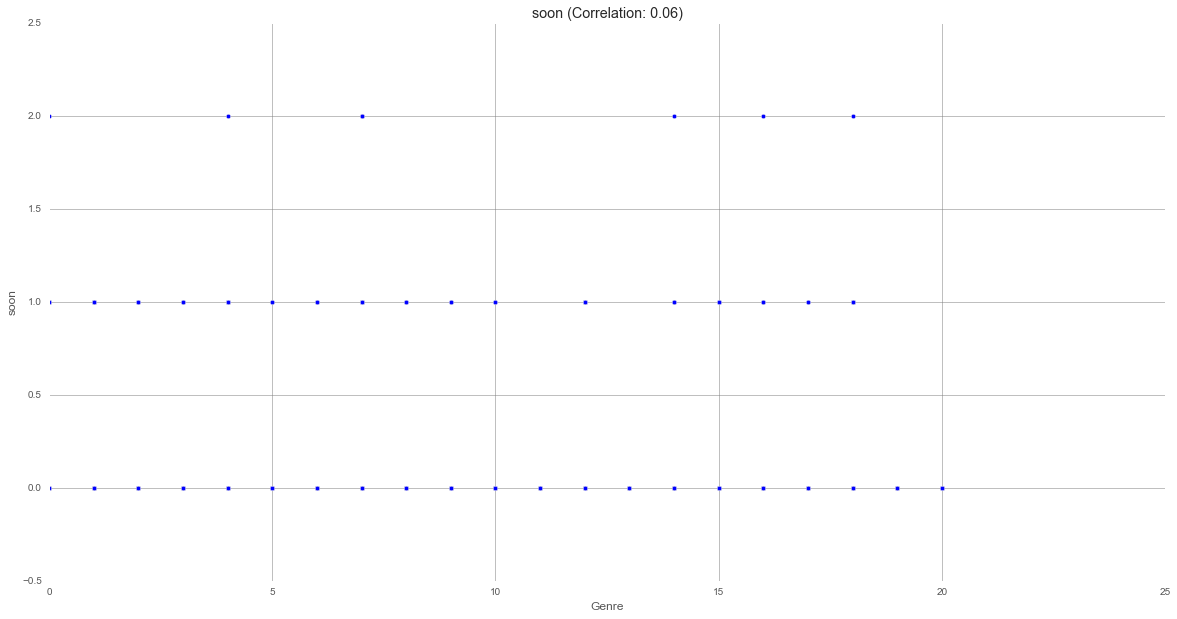

(0, 25.0)

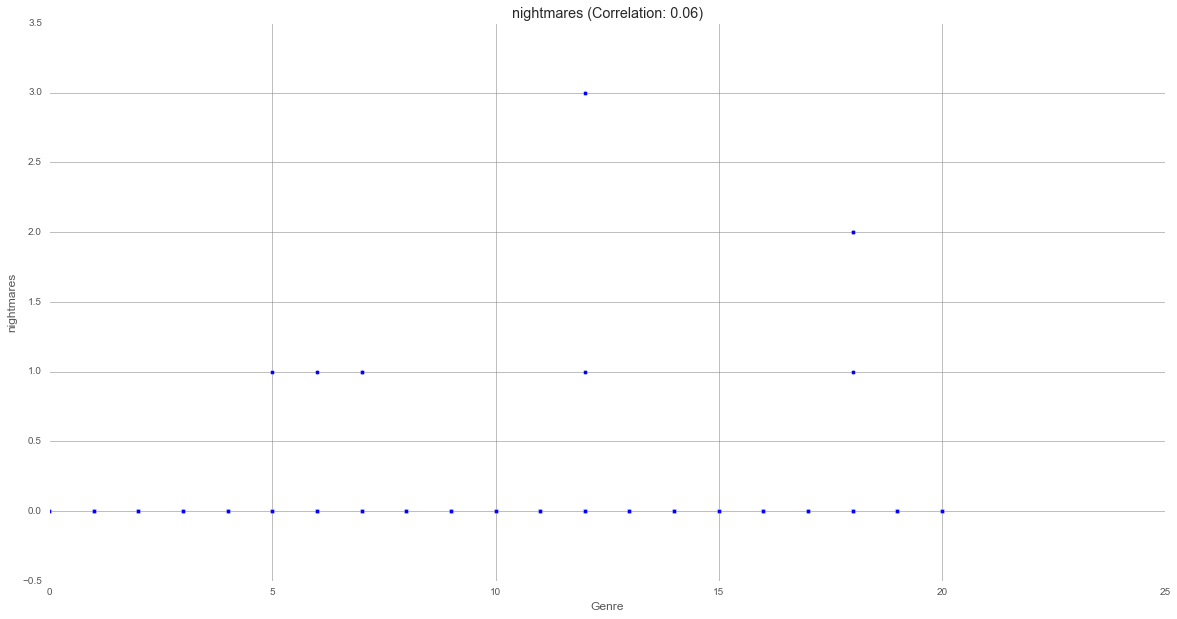

(0, 25.0)

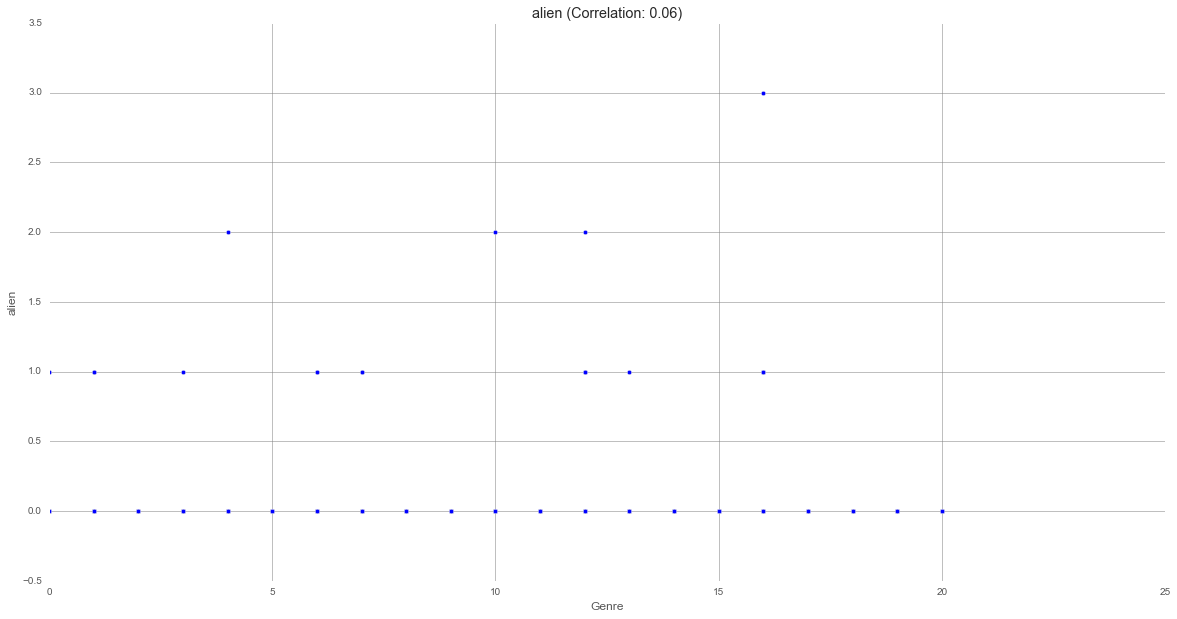

(0, 25.0)

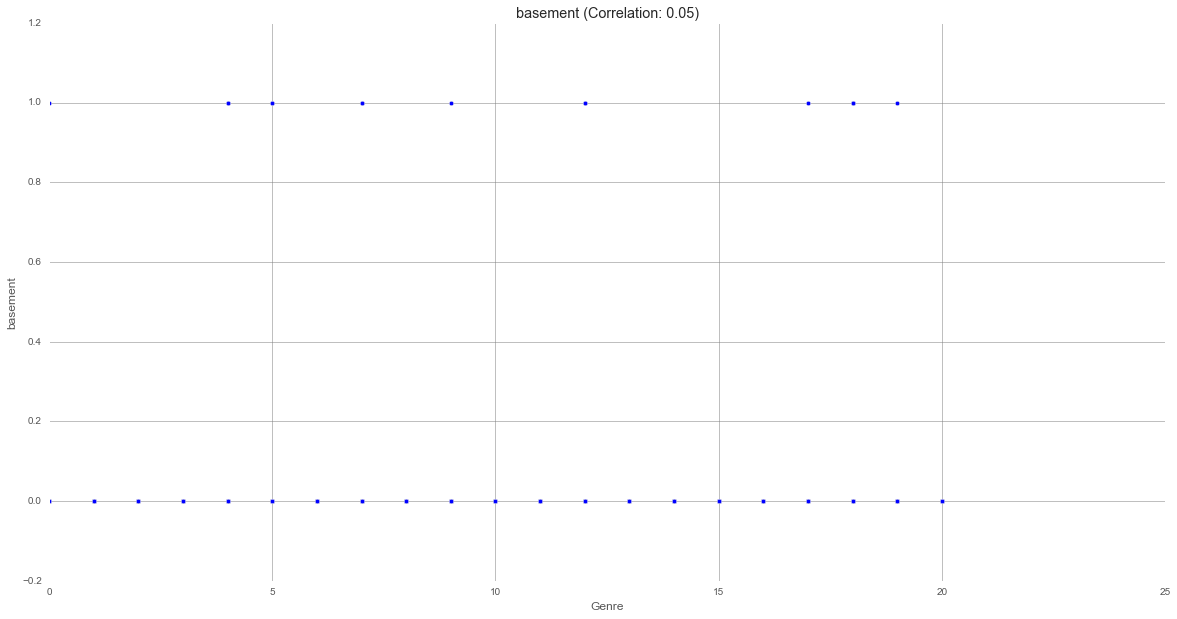

(0, 25.0)

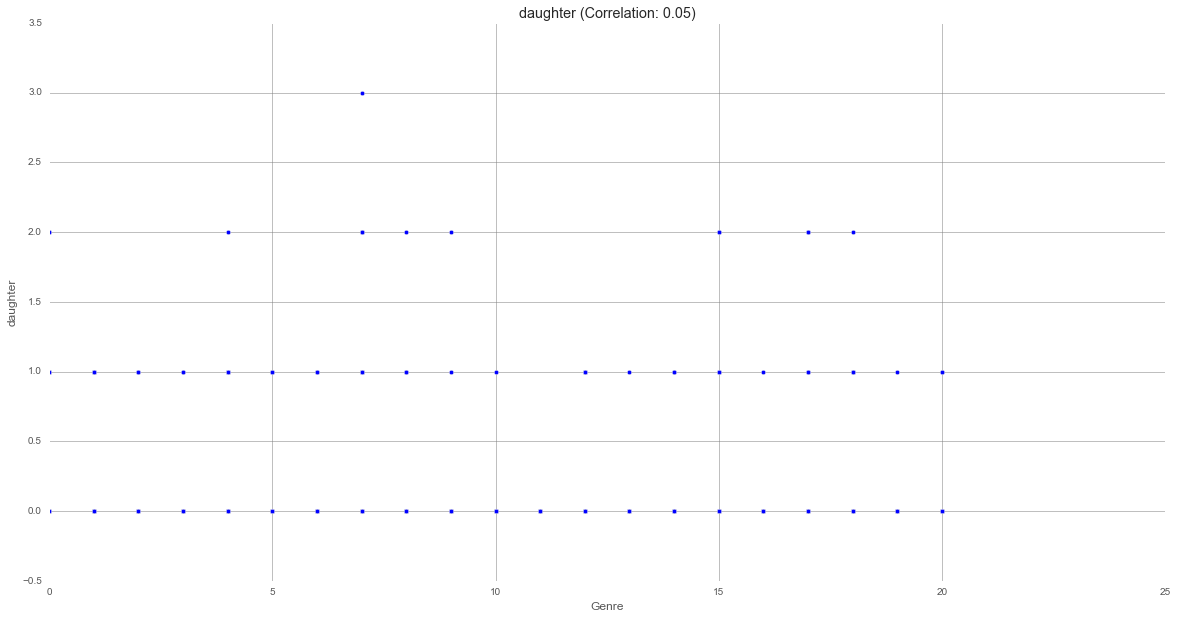

(0, 25.0)

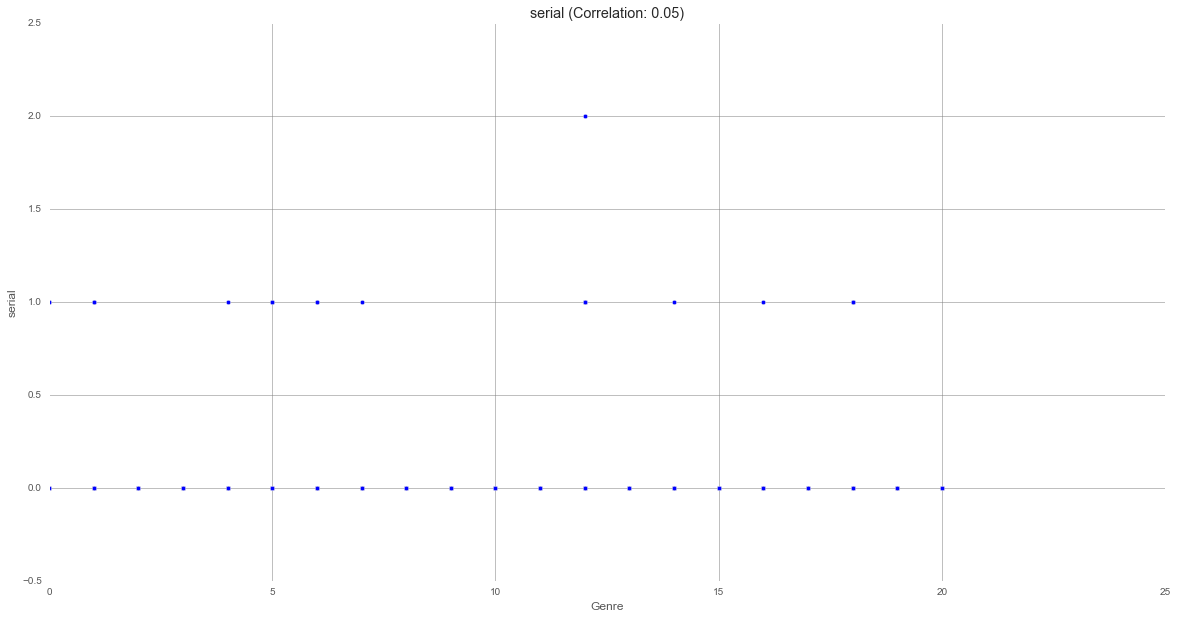

(0, 25.0)

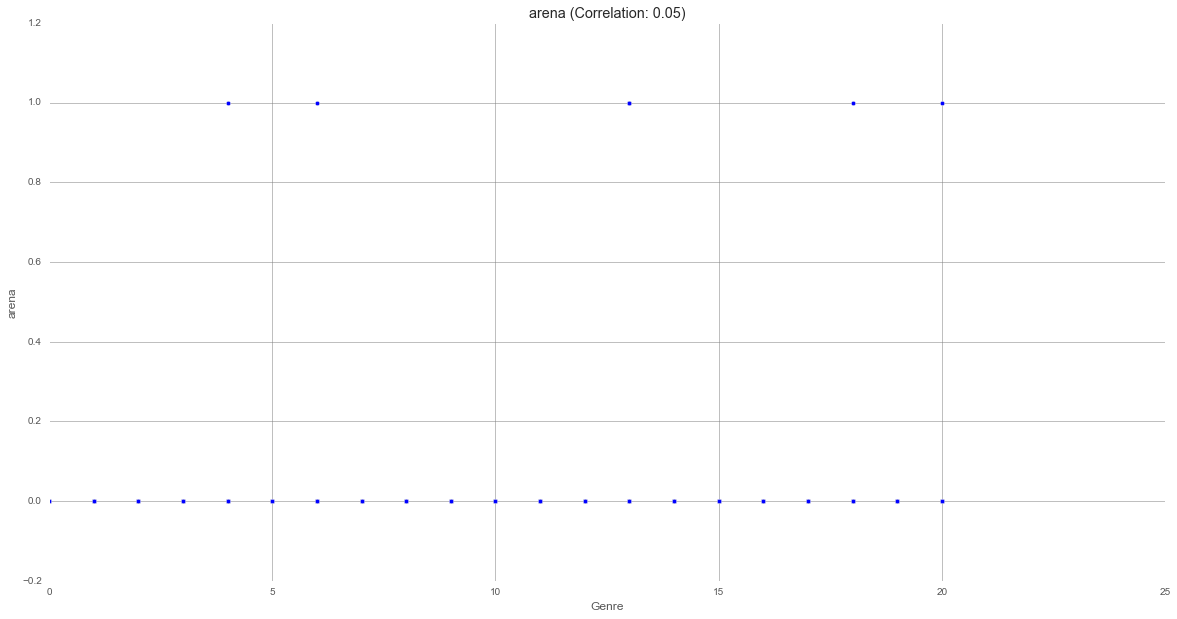

(0, 25.0)

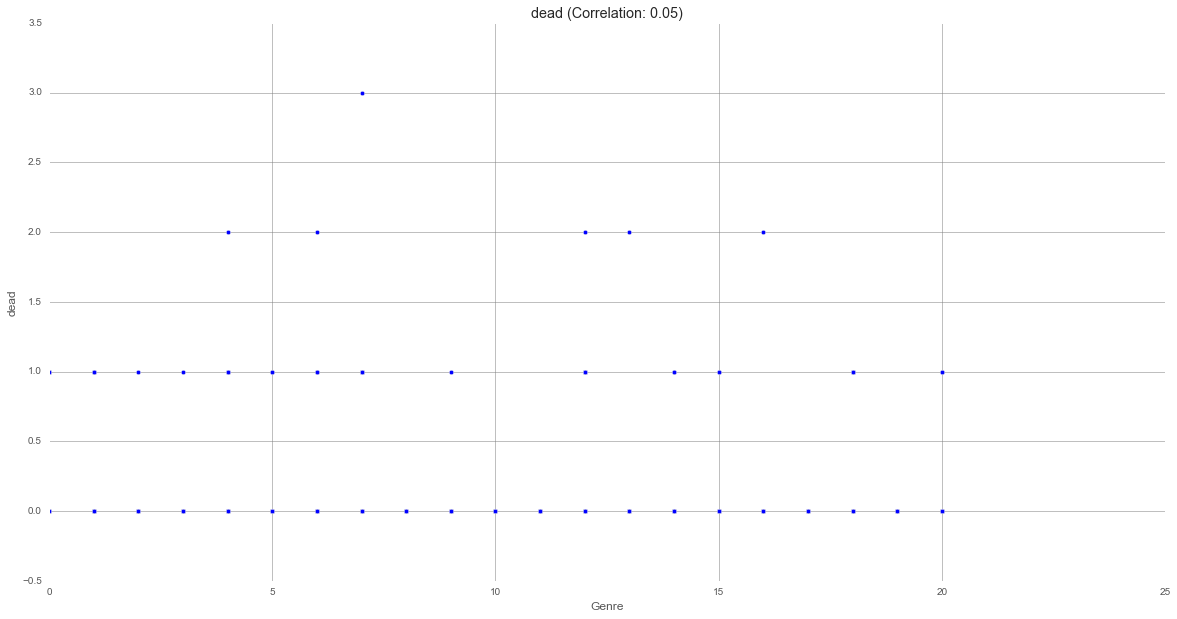

(0, 25.0)

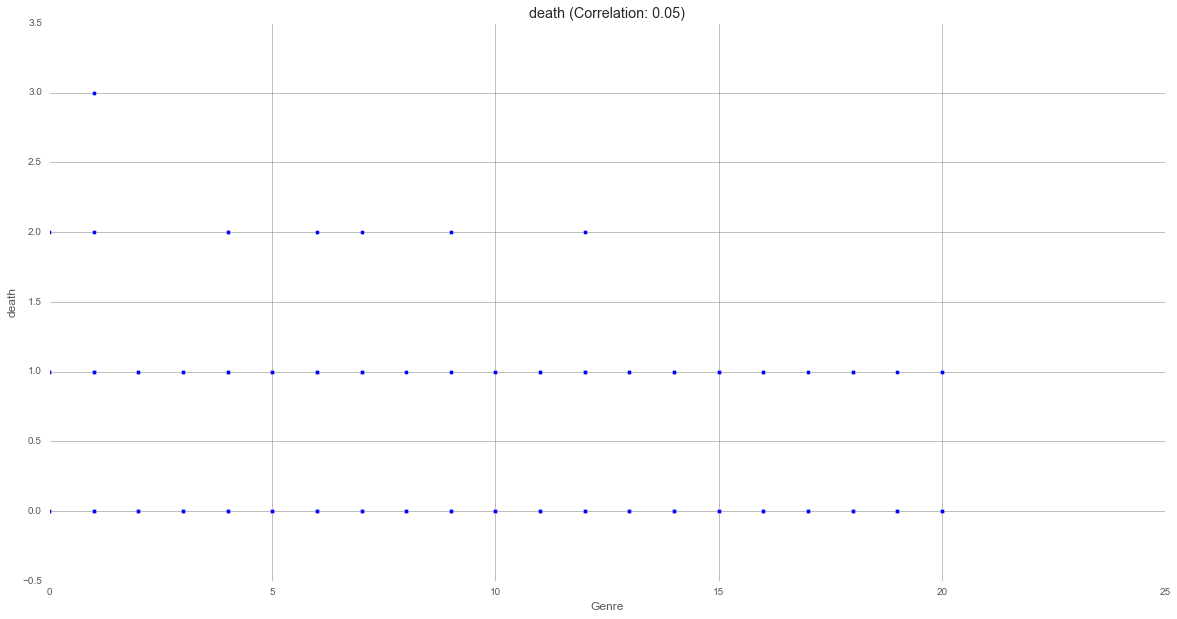

(0, 25.0)

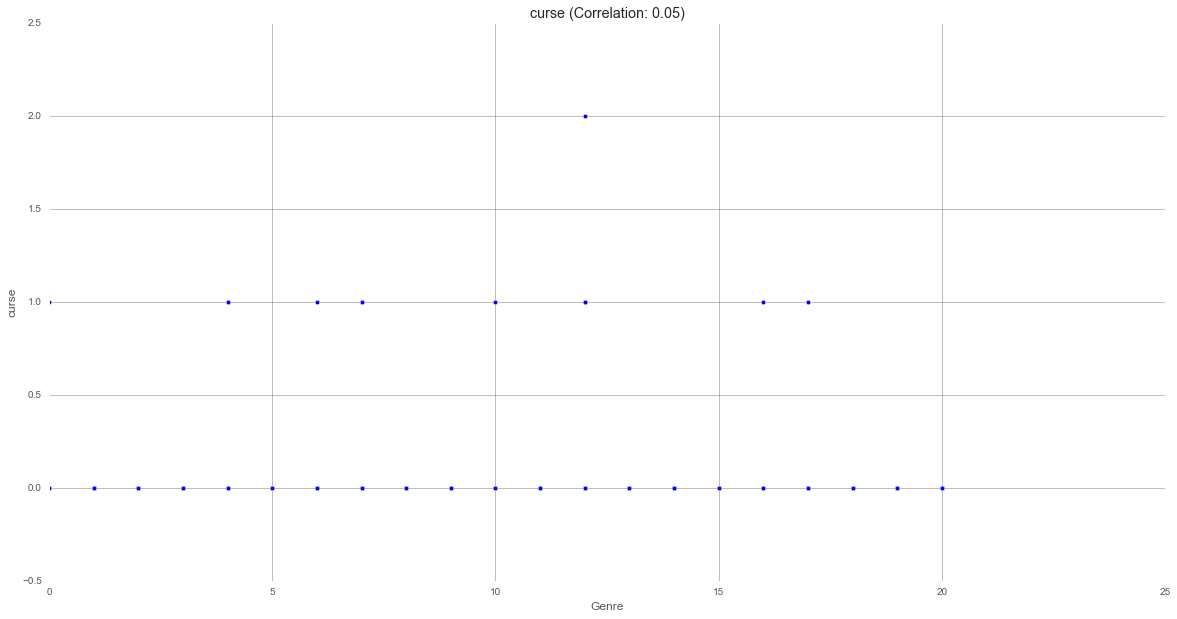

(0, 25.0)

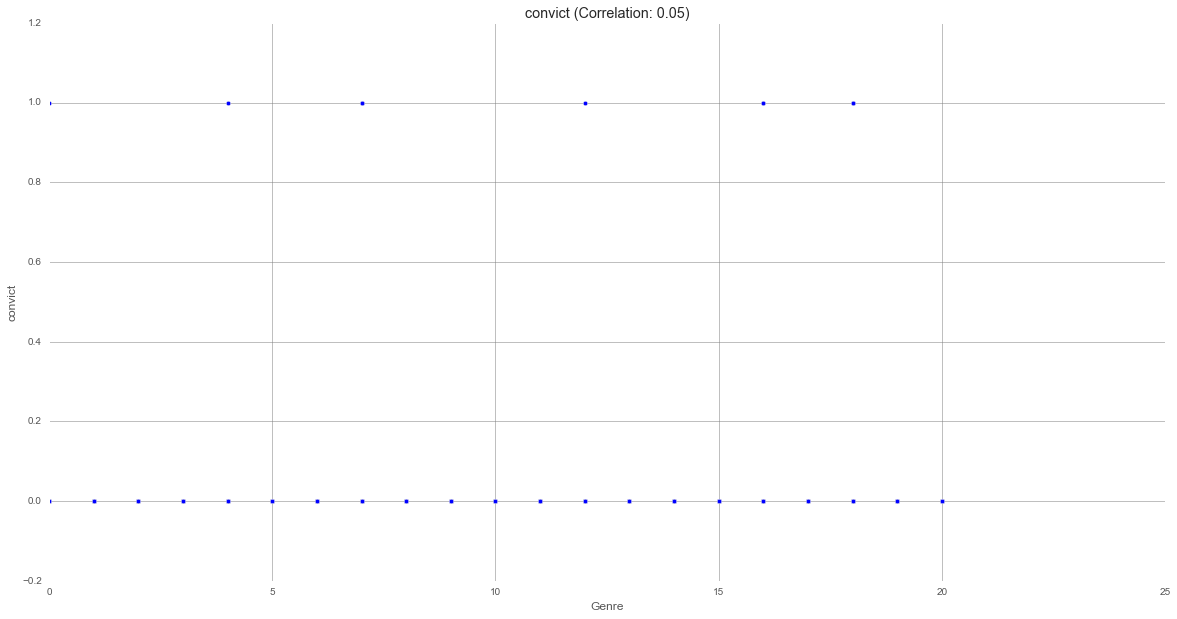

(0, 25.0)

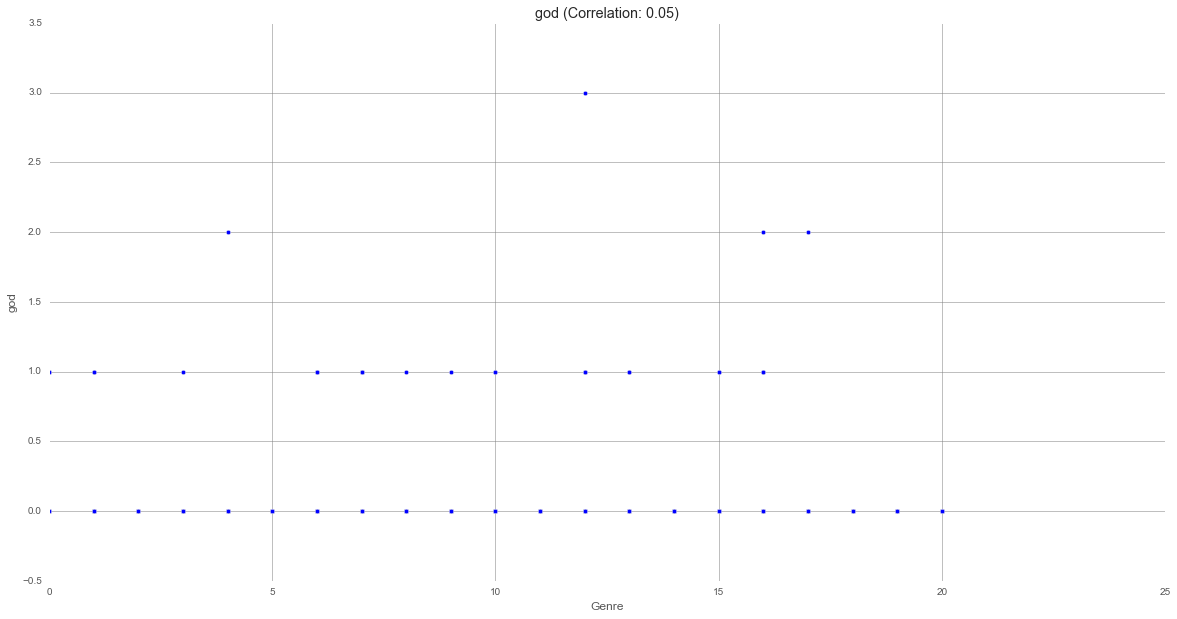

(0, 25.0)

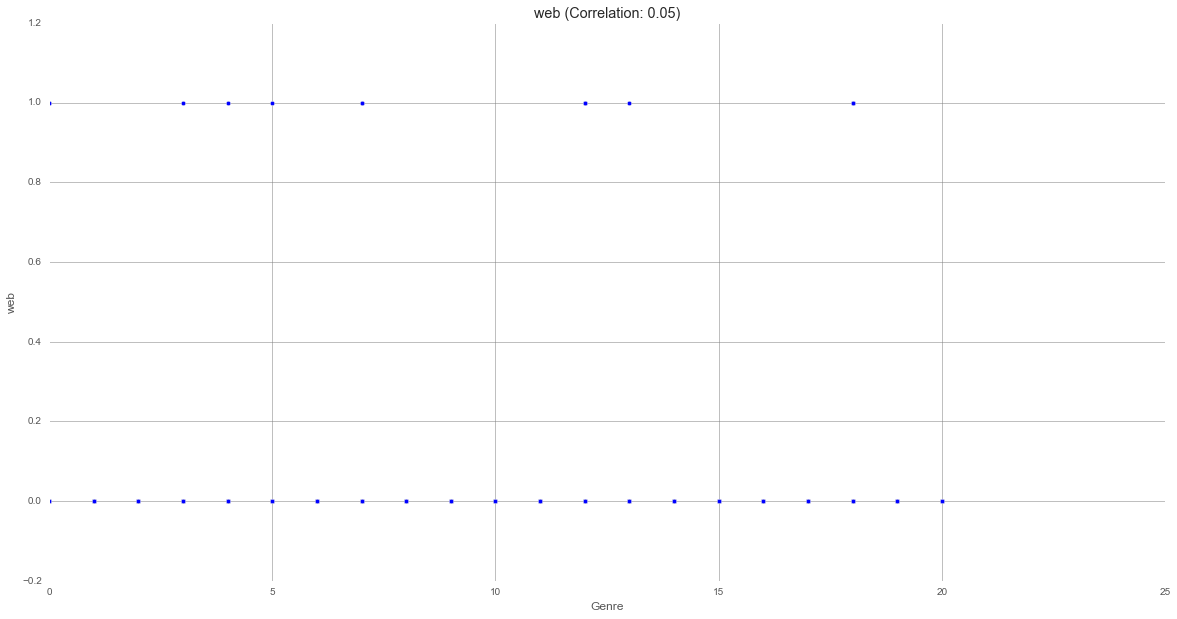

(0, 25.0)

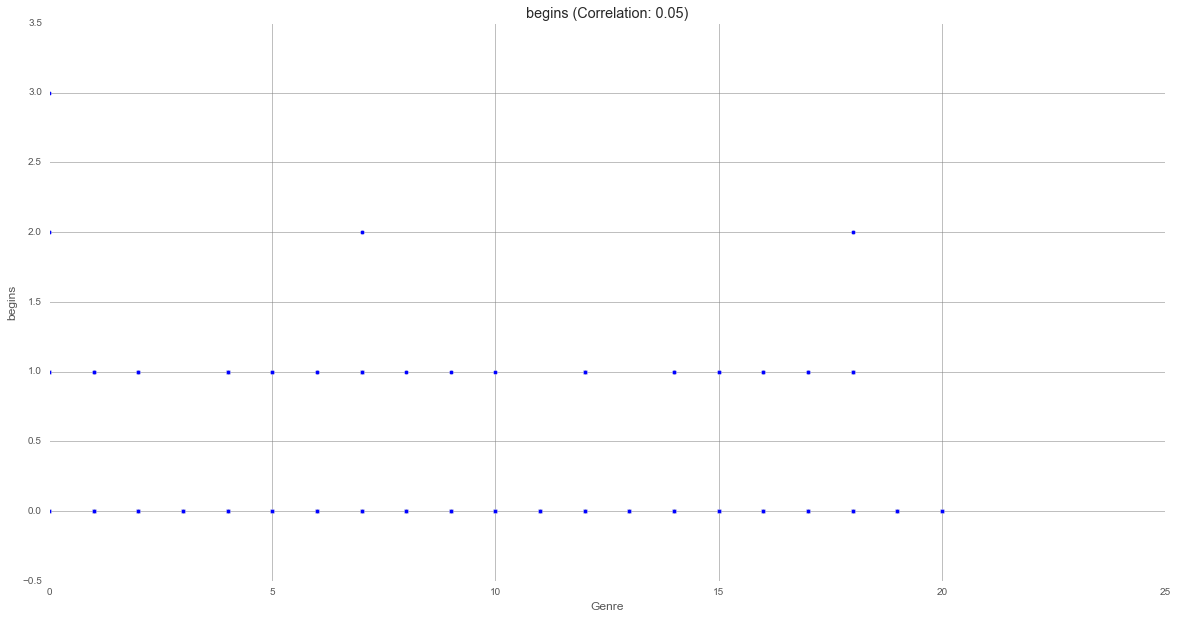

(0, 25.0)

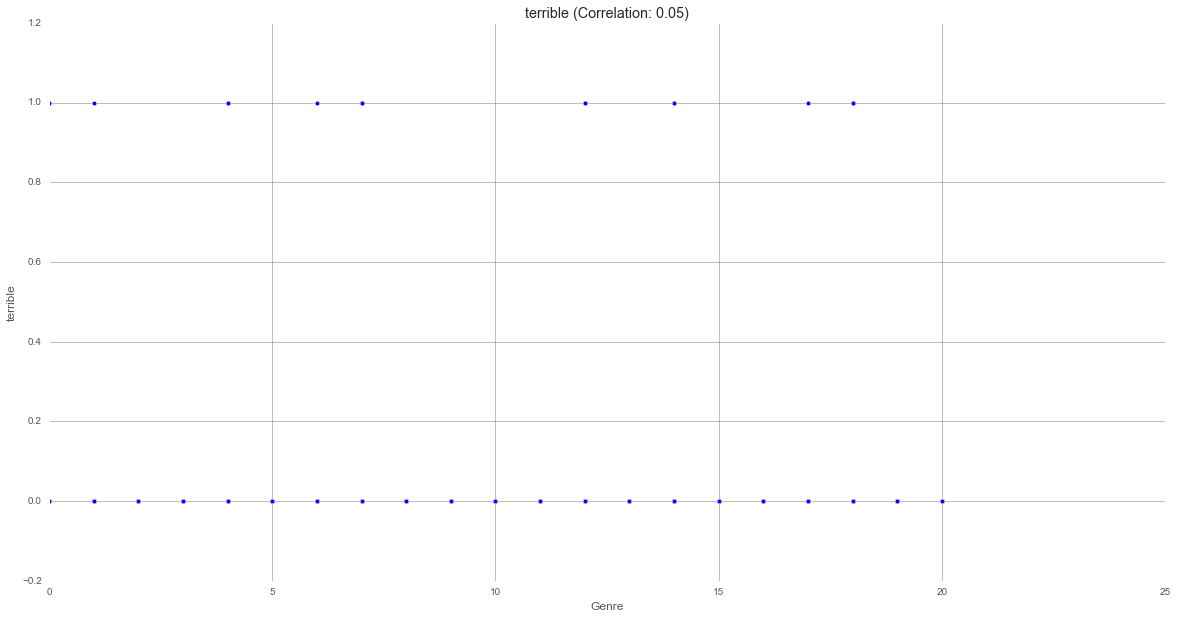

(0, 25.0)

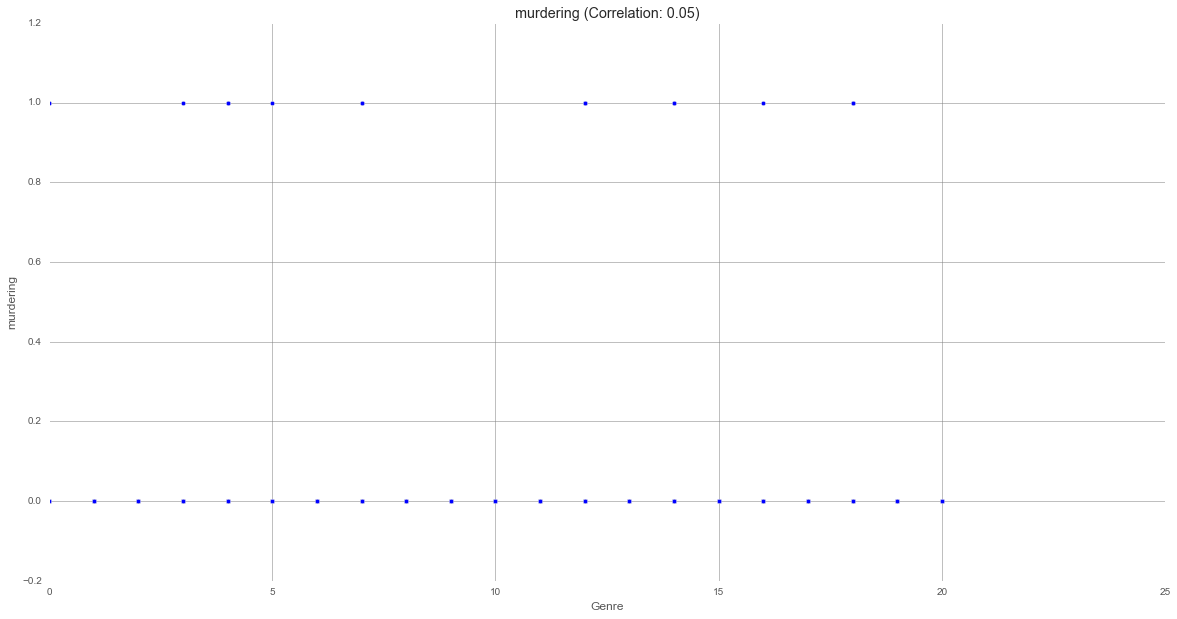

ValueError: x and y must be the same size

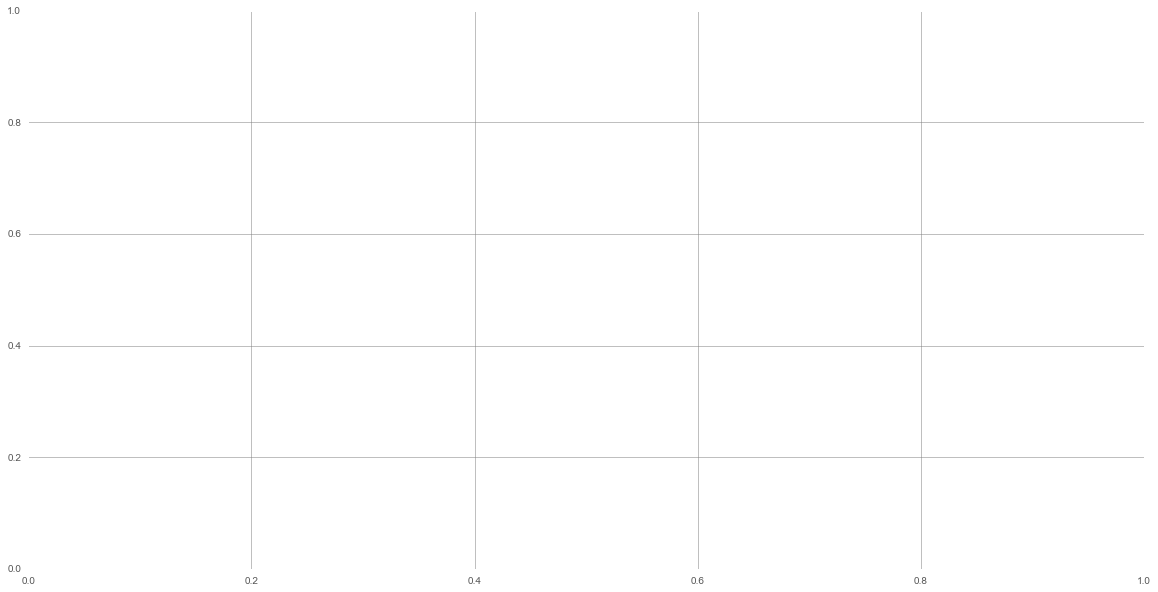

In [56]:
#Plot genre and predictor variables in scatter plot if correlation is over positive or negative %3 
for i in range(len(ass_corr)):
    if ((ass_corr[i] > 0.03) | (ass_corr[i] < -0.03)): 
        plt.scatter(tmdb_df['genres'], tmdb_df[ass_corr.index[i]])
        plt.xlabel('Genre')
        plt.title(ass_corr.index[i] + ' (Correlation: ' + str(round(ass_corr[i],2)) +')')
        plt.ylabel(ass_corr.index[i])
        plt.xlim(0)
        plt.show()

It seems that even though it is still a weak correlation, production country and company are among the most correlated variables. This might make sense, we can expect that a country such as US might produce movies from all genres but some countries might be specializing in genres more than others. It is also probable that some production companies are focusing on particular genres. vote_average is also slightly correlated with genres, showing that some genres might be getting higher scores than others. 

A couple of the weakly correlated variables are runtime, popularity and vote count. 

It seems that from these variables we would achieve a low prediction accuracy, therefore using deep learning methods such as image recognition to analyze posters or natural language processing to analyze movie plots might increase our performance greatly. 

## <span style="color:#08088A">  SUMMARY:  </span> 


### <span style="color:#08088A">  Discussion about the imbalanced nature of the data and how we will address it:  </span> 
 
It seems that some genres are much more frequent than others, for example out of a sample of about 6500 movies, Western genre is observed 19 times while Drama is observed 1200 times. This makes accurate prediction difficult as the data is imbalanced. We have two ways to address this:
-      We would have to either sample the data so that each genre is observed with the same frequency – such as 100 observations per genre
-      Incorporate a balancing weights to our model.
 
Our recommendation is incorporate balancing weights to our model. Do you agree, let’s discuss?
 
 
### <span style="color:#08088A">  Description of our data:  </span> 
 
Our data is a merged database through IMDB IDs using TMDB and IMDB sources. The TMDB data includes metadata such as popularity, production company, production country, average vote score.  TMDb also provides the movie posters in addition to the metadata. You can find below description of variables below: 
 
**TMDB Data Description**
 
Adult: A logical value that indicates if a movie is only for adult people (TRUE) or not (FALSE). backdrop_path: The backdrop of the movie. 
belong_to_collection: The collections to which the movie belongs. 
Budget: The budget for the movie.
Genres: The movie’s genre. 
Homepage: The movie’s homepage.
Id: The movie ID.
imdb_id: The movie imdb ID. 
original_language: The original language of the movie. 
original_title: The original title of the movie. 
Overview: A brief plot. 
Popularity: An index of the movie’s popularity.
poster_path: The poster of the movie. 
production_companies: The producer companies.
production_countries: The countries involved in the production. 
release_data: The date of the release. 
Revenue: The movie’s income.
Runtime: The length of the movie. 
spoken_language: The language spoken in the movie. 
Status: The movie’s status. 
Tagline: The movie’s tagline. 
Title: The movie’s title. 
Video: The videos associated to the movie. 
vote_average: The average of the votes.
vote_count: The number of votes.                    
 
**IMDB Data Description**
 
director: Person list; a list of director's name (e.g.: ['Brian De Palma'])
cast: Person list; list of actor/actress, with the currentRole instance
                   variable set to a Character object which describe his
                   role/duty.
writer: Person list; list of writers ['Oscar Fraley (novel)']
rating: string; user rating on IMDb from 1 to 10 (e.g. '7.8')
votes: string; number of votes (e.g. '24,101')
runtimes: string list; in minutes ['119'] or something like ['USA:118',
          'UK:116']
genres: string list; one or more in (Action, Adventure, Adult, Animation,
                                         Comedy, Crime, Documentary, Drama, Family, Fantasy, Film-Noir,
                                         Horror, Musical, Mystery, Romance, Sci-Fi, Short, Thriller,
                                         War, Western) and other genres defined by IMDb.
akas: string list; list of aka for this movie
certificates: string list; ['UK:15', 'USA:R']
mpaa: string; the mpaa rating
 

 
### <span style="color:#08088A">  Our choice of Y:  </span> 
 
It seems that choosing genre data in TMDB and IMDB is a complicated process as some movies do not have any genres at all, there might be multiple genres in each source and there might be conflicting genre data in TMDB and IMDB. Ideally we would like to end up with one genre for each movie with high accuracy. In order to achieve this, we would like use a systematic approach to assign a genre for each movie:
            
-      Check for the genre suggestion in both TMDB and IMDB, pick the genre that is common in both
-      If there are multiple genres that are common in both databases, pick one of the genres randomly
-      If there are no common genres, pick a genre randomly
-      If genre data is missing in one of the sources, pick a genre from the other source randomly
 
Using the systematic approach our aim is to pick the genres that is suggested by both sources, but if there are no common genres then we will pick the genre randomly. This way we will end up with a genre for each movie. 
 
### <span style="color:#08088A">  Features chosen for X:  </span> 
 
Our database is a combination of metadata, poster images, plot summary word vectors,

**Metadata:**Our correlation analysis shows that even though some metadata features will be useful in our prediction such as production company, production country and voting average, overall there is weak correlation with genre. Therefore our prediction accuracy would be low if we only use metadata from TMDB and IMDB.  In addition to the metadata that have correlation over 3% with genre, we will incorporate Image recognition of posters and natural language processing of plot summaries / actors, writer and directors to help us improve our accuracy. 

**Actors/directors/writers:** can also be useful in predicting genre, common sense tells us that some actors regularly act in comedies, some act in dramas etc. We can also treat each actor/writer/director as a feature. 

**Posters:**  We will convert each poster into pixels and use PCA to reduce dimensionality. Top PC scores that represent 90% of the variance can be used
 
**Plot summaries:** Our aim is to analyse plot summaries by turning each plot into a vector of features. We will tokenize and count the word occurrences using a bag of words approach. Individual token occurrence frequency (normalized or not) will be treated as a feature, as features will then enable us to predict the genre. 
 
### <span style="color:#08088A">  Features chosen for X:  </span> 

We decided on your random element in a few different ways.

Use a date as your random seed data. Randomly pick a date and use something like primary_release_date.gte then pick a page and item from the results array.
 